In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

#from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [2]:
gammas_search = [0.25, 0.5] #, 0.75]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8448/2300007364.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8448/2300007364.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_8448/2300007364.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"sce

In [3]:
#from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")
model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [4]:
from diagnostic_plots import convergence_plot
from utils import create_df_response


id_run       = 0
posterior_df = pd.DataFrame()

for idx_row, row in scenarios_large_df.iterrows():
    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θmle      = inference["mle"]
    θpost     = inference["posterior"]
    y_sim     = inference["observations"]
    θtruth    = inference["teta_truth"]
    idx_infer = inference["idx_infer"]
    Nif       = θpost.shape[-1]

    ρ_post = θpost[0, :, :, :].mean(-2).flatten()
    β_post = θpost[1, :, :, :].mean(-2).flatten()

    post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
    post_df["value"]       = np.concatenate([ρ_post, β_post])
    post_df["value_truth"] = np.concatenate([θtruth[0, 0] * np.ones_like(ρ_post),
                                                θtruth[1, 0] * np.ones_like(β_post)])

    post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
    post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
    post_df["gamma"]    = row.gamma
    post_df["scenario"] = idx_row

    posterior_df        = pd.concat([posterior_df, post_df])

In [5]:
from utils_local import plot_utils
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]


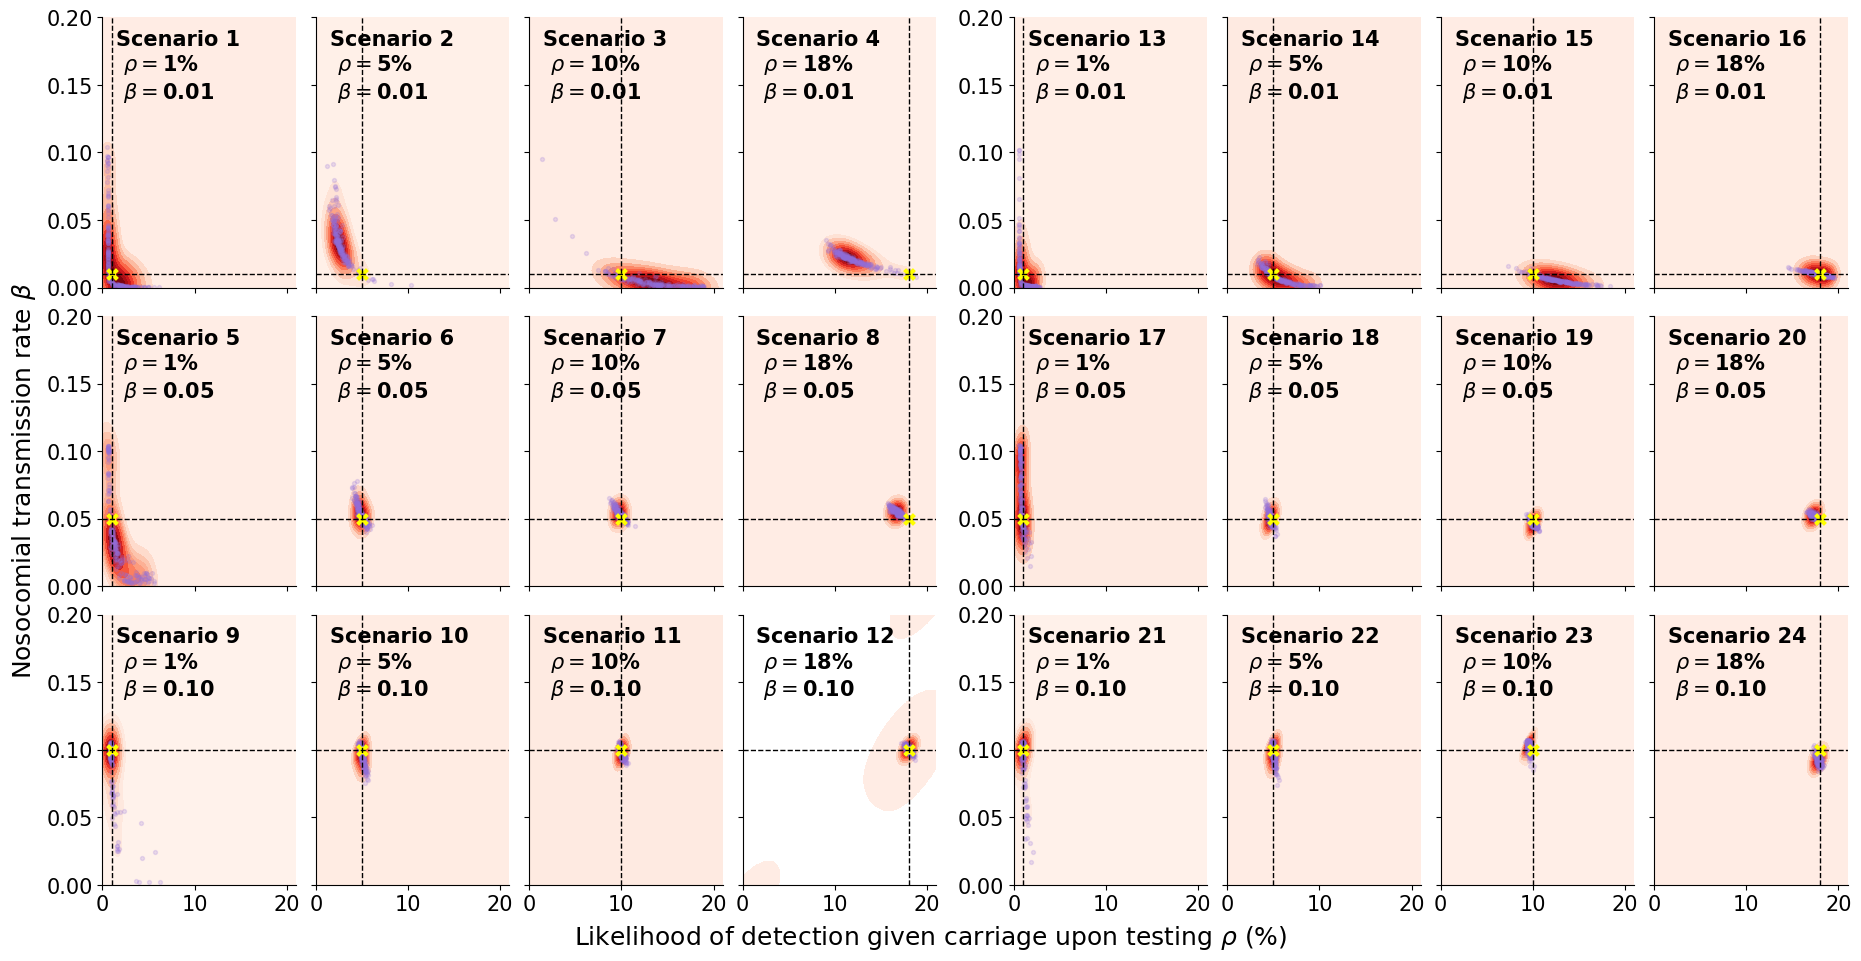

In [9]:
fig     = plt.figure(constrained_layout=True, figsize=(18.5, 9.5))
subfigs = fig.subfigures(1, 2, hspace=0.07, wspace=0.01, width_ratios=[0.5, 0.5])

######################## figure A, γ = 25% ######################################
axes1    = subfigs[0].subplots(3, 4, sharex=True, sharey=True)
for idx_scenario, ax in enumerate(axes1.flatten()):
    p_df             = v_df[v_df.gamma == 0.25]
    p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
    rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
    beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
    rho_df["value"]  = rho_df["value"] * 100

    sns.kdeplot(ax    = ax,
                x     = list(rho_df["value"].values) + [0, 20],
                y     = list(beta_df["value"])       + [-0.02, 0.22],
                cmap  = "Reds",
                fill  = True,  thresh=0)
    ax.scatter(x          = rho_df["value"],
                y         = beta_df["value"],
                facecolor = "mediumpurple",
                edgecolor = None, alpha=0.2, s=8)

    ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
    ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

    ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                y         = beta_df["value_truth"].drop_duplicates(),
                marker    = "x",
                facecolor = "yellow",
                lw        = 3,
                s         = 50)

    ax.text(x = 1.5,
            y = 0.14,
            s = "Scenario {}\n".format(p_df.scenario.unique()[0]+1)+r" $\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                    r" $\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
            weight='bold', color="k")

    ylim = ax.get_ylim()
    ax.set_ylim((0, 0.2))
    ax.set_xlim((0, 21))

    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

#for i in range(4):
#    axes1[-1, i].set_xlabel(r"$\rho$ (%)")
#
#for i in range(3):
#    axes1[i, 0].set_ylabel(r"$\beta$")
#
#################################################################################

######################## figure B, γ = 50% ######################################
axes2    = subfigs[1].subplots(3, 4, sharex=True, sharey=True)
for idx_scenario, ax in enumerate(axes2.flatten()):
    p_df             = v_df[v_df.gamma == 0.5]
    p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
    rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
    beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
    rho_df["value"]  = rho_df["value"] * 100

    sns.kdeplot(ax     = ax,
                x      = list(rho_df["value"].values) + [0, 20],
                y      = list(beta_df["value"])       + [-0.02, 0.22],
                cmap   = "Reds",
                fill   = True,
                thresh = 0)

    ax.scatter(x          = rho_df["value"],
                y         = beta_df["value"],
                facecolor = "mediumpurple",
                edgecolor = None, alpha=0.2, s=8)

    ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0],      c="k", lw=1, ls="--")
    ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, c="k", lw=1, ls="--")

    ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                y         = beta_df["value_truth"].drop_duplicates(),
                marker    = "x",
                facecolor = "yellow",
                lw        = 3,
                s         = 50)
    ax.text(x = 1.5,
            y = 0.14,
            s = "Scenario {}\n".format(p_df.scenario.unique()[0]+1)+r" $\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                    r" $\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
            weight='bold', color="k")

    ylim = ax.get_ylim( )
    ax.set_ylim((0, 0.2))
    ax.set_xlim((0, 21))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

#for i in range(4):
#    axes2[-1, i].set_xlabel(r"$\rho$ (%)")

#for i in range(3):
#    axes2[i, 0].set_ylabel(r"$\beta$")

fig.supxlabel(r'Likelihood of detection given carriage upon testing $\rho$ (%)')
fig.supylabel(r'Nosocomial transmission rate $\beta$')

#################################################################################

fig.savefig(os.path.join(results2_dir, "paper_figures", "fig2.png"),
                                            dpi=300, transparent=True)

